In [1]:
import glob
import os, sys
import pickle
import re

import numpy as np
import pandas as pd
from typing import Union, List

# sys.path.append('/home/cbazin/programs/reeds/')
import reeds
from pygromos.files import repdat
from pygromos.utils import bash

import matplotlib.pyplot as plt

from reeds.function_libs.visualization import plots_style as ps


# Loading the data from a single directory

In [2]:
project_dir = "//fileserver/pine/pine2/cchampion/REEDS/1_genentech_project/CHK1_benset/complex_gaff/d_mixed_opt/analysis"

In [61]:
project_dir = "//fileserver/pine/pine2/cchampion/REEDS/1_genentech_project/CHK1/gaff/d_mixed_opt/analysis"

In [63]:
#out_dir = bash.make_folder(out_dir)

# analyse the individual iterations
sopt_data = {}
num_iters = 6

for iteration in range(1, num_iters+1):
    print( iteration, end="\t")
    out_iteration_file_path = f'{project_dir}/mixedOpt{iteration}_ana_data.npy'
    
    print (out_iteration_file_path)
    
    if (os.path.exists(out_iteration_file_path)):
        print("\n\nLoading precomputed data for iteration: ", end="\t")
        opt_it_stats = pickle.load(open(out_iteration_file_path, "rb"))
        sopt_data.update({iteration: opt_it_stats})

1	//fileserver/pine/pine2/cchampion/REEDS/1_genentech_project/CHK1/gaff/d_mixed_opt/analysis/mixedOpt1_ana_data.npy


Loading precomputed data for iteration: 	2	//fileserver/pine/pine2/cchampion/REEDS/1_genentech_project/CHK1/gaff/d_mixed_opt/analysis/mixedOpt2_ana_data.npy


Loading precomputed data for iteration: 	3	//fileserver/pine/pine2/cchampion/REEDS/1_genentech_project/CHK1/gaff/d_mixed_opt/analysis/mixedOpt3_ana_data.npy


Loading precomputed data for iteration: 	4	//fileserver/pine/pine2/cchampion/REEDS/1_genentech_project/CHK1/gaff/d_mixed_opt/analysis/mixedOpt4_ana_data.npy


Loading precomputed data for iteration: 	5	//fileserver/pine/pine2/cchampion/REEDS/1_genentech_project/CHK1/gaff/d_mixed_opt/analysis/mixedOpt5_ana_data.npy


Loading precomputed data for iteration: 	6	//fileserver/pine/pine2/cchampion/REEDS/1_genentech_project/CHK1/gaff/d_mixed_opt/analysis/mixedOpt6_ana_data.npy


Loading precomputed data for iteration: 	

# Make the plots

In [73]:
ALL_RTS = None

def visualization_s_optimization_summary(s_opt_data: dict,
                                         out_path: str = None,
                                         nRT_range: List[float] = None,
                                         avRT_range: List[float] = None, 
                                         nsteps: float = 50) -> Union[str, plt.figure]:
    """visualization_s_optimization_summary
    Parameters
    ----------
    s_opt_data : dict
        dictionary containing data of all optimization iterations
    out_path : str, optional
        path to save figure
    nRT_range : List[float]
        range for the plot of number of roundtrips
    avRT_range : List[float]
        range for the plot of roundtrip times
    nsteps: float 
        number of steps between two exchange trials
    Returns
    -------
    Union[str, plt.figure]
        the outpath is returned if one is given. Alternativley the plot direclty will be returned.
    """
    niterations = len(s_opt_data)
    
    x = np.linspace(1, niterations, niterations)
    
    num_roundtrips = []
    std_num_roundtrips = []
    
    avg_roundtrip_time = []
    
    x_svalues = []
    y_svalues = []
    
    bar_heights = []
    
    # Format data properly for plotting:
    
    all_roundtrips = np.zeros([niterations, 32])
    
    for i, key in enumerate(sorted(s_opt_data)):
        
        opti = s_opt_data[key]
        num_roundtrips.append(opti['avg_nRoundtripsPerNs'])
        all_roundtrips[i] =  [ v['roundtrips_per_ns'] for k, v in (opti['stats_per_replica'].items())]

            
        std_num_roundtrips.append(np.std([ v['roundtrips_per_ns'] for k, v in (opti['stats_per_replica'].items())]))
        
        avg_roundtrip_time.append(np.nan_to_num(opti['avg_rountrip_durations']))
        
        x_svalues.extend(opti["s_values"])
        y_svalues.extend([(i+1) for x in range(len(opti["s_values"]))])
        
        bar_heights.append([opti["state_maxContributing_sampling"][state] for state in opti["state_maxContributing_sampling"]])
        
    # Convert the number of steps into a time 
    avg_roundtrip_time = np.array(avg_roundtrip_time) * 0.002 * nsteps
    
    # Plot the formatted data: 
    
    #fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=[12, 8])
    
    fig = plt.figure(constrained_layout=True, figsize = [10, 6])
    mosaic = """
        AB
        CB
        """
    
    gridspec_kw = { 'height_ratios':[0.85, 1], 'width_ratios':[1, 0.65]}
    
    ax_dict = fig.subplot_mosaic(mosaic, gridspec_kw = gridspec_kw)
    
    ax1 = ax_dict['A']
    ax3 = ax_dict['B']
    ax4 = ax_dict['C']
    
    alphas = [i/niterations* 0.8 + 0.2 for i in range(niterations)]
    
    #for i in range(niterations):   
        #ax1.bar(x=x[i], height=num_roundtrips[i], yerr = std_num_roundtrips[i], color="dimgray", alpha = alphas[i])
    bplot = ax1.boxplot(x=all_roundtrips.T, showfliers=False, medianprops=dict(color="black"), patch_artist=True)
    alphas = [i/niterations* 0.8 + 0.2 for i in range(niterations)]
    for i, box in enumerate(bplot['boxes']):
        box.set(color='dimgray', linewidth =2)
        box.set_alpha(alphas[i])

    # ax1.set_title("Average number of roundtrips")
    ax1.set_title("Average number of roundtrips",fontsize = 18)
    ax1.set_xlabel("iteration", fontsize = 14)
    ax1.set_ylabel(r"$\overline{n_{rt}}$   [ns$^{-1}$]", fontsize = 18)
    
    
    
    ax1.set_xticks(x)
    
    #ax1.set_xticks(x)

    if (not isinstance(nRT_range, type(None))):
        ax1.set_ylim(nRT_range)
    

    # Plot of the s-distribution
    ax3.scatter(x=y_svalues, y=x_svalues, marker = 'x', c="black", s = 4)    
 
    ax3.set_xticks(x)

    # ax3.set_title("s-distribution")
    ax3.set_xlabel("iteration", fontsize = 14)
    
    ax3.set_ylabel("s-value  [a.u.]", fontsize = 14)
    ax3.set_title("s - distribution",fontsize = 18)
    ax3.set_yscale('log')
    
    
    
    # Making the bottom right corner plot
    num_sopts = len(bar_heights)
    num_states = (len(bar_heights[0]))

    labels = [str(i) for i in range(1, num_states+1)]

    # Making the offsets between the different bars

    width = 1 / (niterations * 1.15)
    # x = np.arange(num_states) + 0.5*num_states*width # the label locations

    num = num_sopts-1

    # finding proper offsets

    if num%2==0:offsets = np.arange(-num/2, num/2+0.001, step =1)
    else:offsets = np.arange(-num/2, num/2+0.001)
    
    active_qualitative_map_mligs = lambda num_ligs: plt.cm.viridis(np.linspace(0,1,num_ligs))
    #active_qualitative_map_mligs = lambda num_ligs: plt.cm.rainbow(np.linspace(0,1,num_ligs))
    colors = active_qualitative_map_mligs(num_states)
        
    for i in range(num_sopts):
        normalized_heights = bar_heights[i]/np.sum(bar_heights[i])
        percent_heights = [100*j for j in normalized_heights]
        
        summed = 0 
        for j , ph in enumerate(percent_heights): # loop over states
            if i == 0:
                ax4.bar(x[i], ph, bottom = summed, color = colors[j], edgecolor = 'black' , linewidth = 1, 
                        label = f'State {j+1}')
            else:
                ax4.bar(x[i], ph, bottom = summed, color = colors[j], edgecolor = 'black' , linewidth = 1)
            summed += ph
                
    ax4.set_xticks(x)
    
    # ax4.hlines(y= 100/num_states, xmin=xmin, xmax=xmax, color="darkgrey", zorder = 0)
    # ax4.set_xlim([0.5, 8.5])
    
    #ax4.set_title("State sampling at $s=1$")
    ax4.set_title("sampling at $s=1$", fontsize = 18)
    ax4.set_xlabel("iteration", fontsize = 14)
    ax4.set_ylabel("population [%]",fontsize = 18)
    
    ax4.legend(fontsize = 10, loc = 'center right', fancybox=True, bbox_to_anchor=(1.35, 0.5))
    
    # use bbox_to_anchor=(1.25, 0.5) for other dataset
    
    for _axis in ax1, ax3, ax4:
        for axis in ['top','bottom','left','right']:
            _axis.spines[axis].set_linewidth(1.35)
            
        #_axis.tick_params(axis="both",direction="in")
    return fig, all_roundtrips #, axes
    

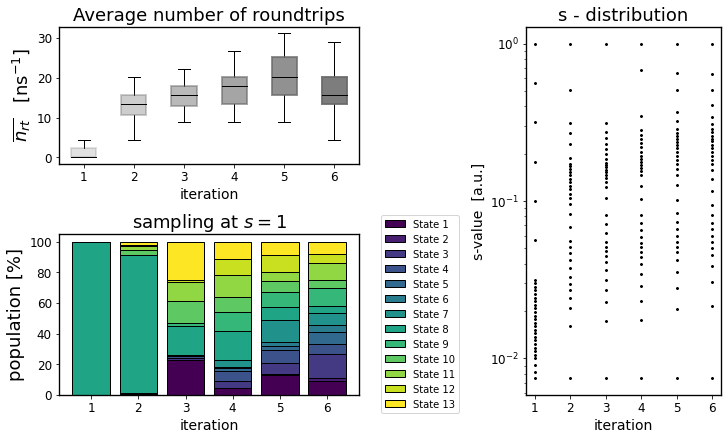

In [74]:
%matplotlib inline
fig, all_rts = visualization_s_optimization_summary(sopt_data)

In [75]:
fig.savefig('/home/cchampion/Downloads/typical_mixed_opt2.png', facecolor='white')

In [25]:
sopt_data

{}